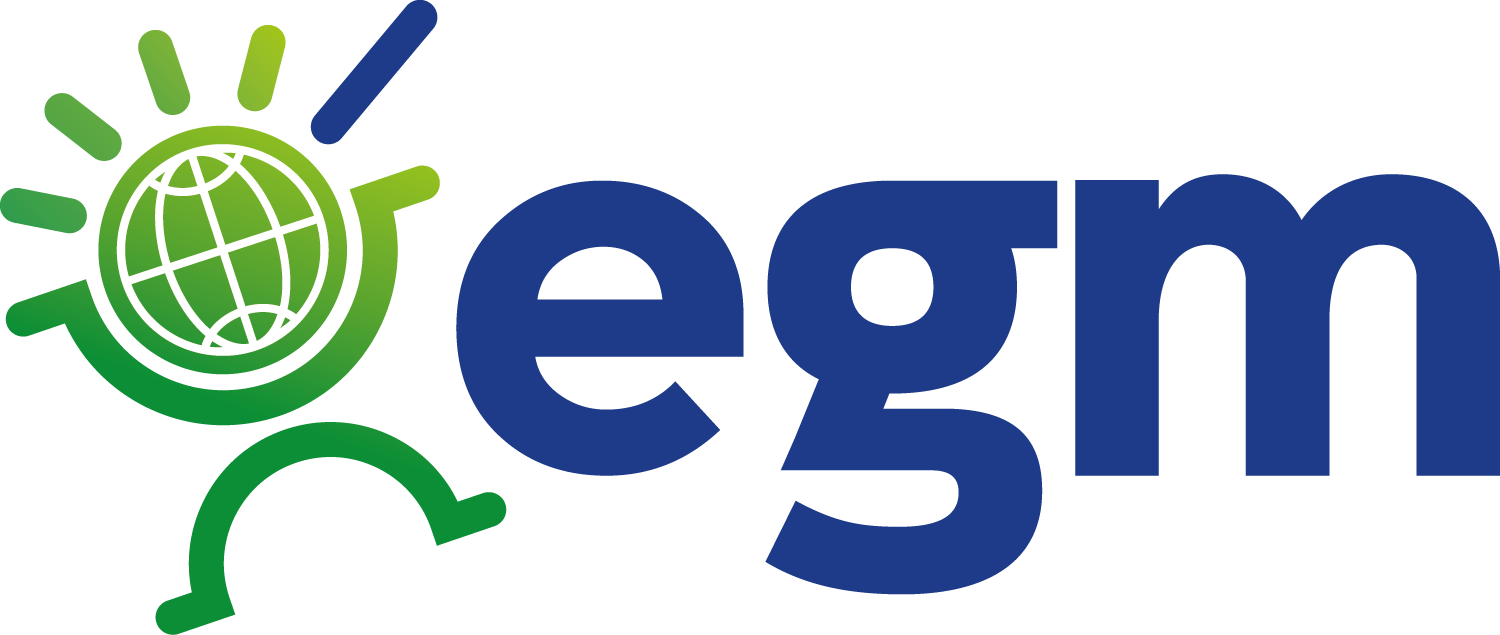

<p style="font-size:30px; color:blue; text-align:center; font-weight: bold">Fiware webinar: MLaaS</p>

### Some imports and configuration

In [1]:
import requests
import json
import pickle
from datetime import datetime
import pytz

In [2]:
import numpy as np

In [3]:
# oauth token
with open('./stellio-dev-access.token', 'rb') as f:
    my_access_token = pickle.load(f)

# headers
headers = {
    'Authorization': 'Bearer ' + my_access_token,
    'Content-Type': 'application/ld+json'
}

# @CONTEXT
AT_CONTEXT = [
        'https://raw.githubusercontent.com/easy-global-market/ngsild-api-data-models/master/mlaas/jsonld-contexts/mlaas-precipitation-contexts.jsonld'
]

___

# Overall diagram

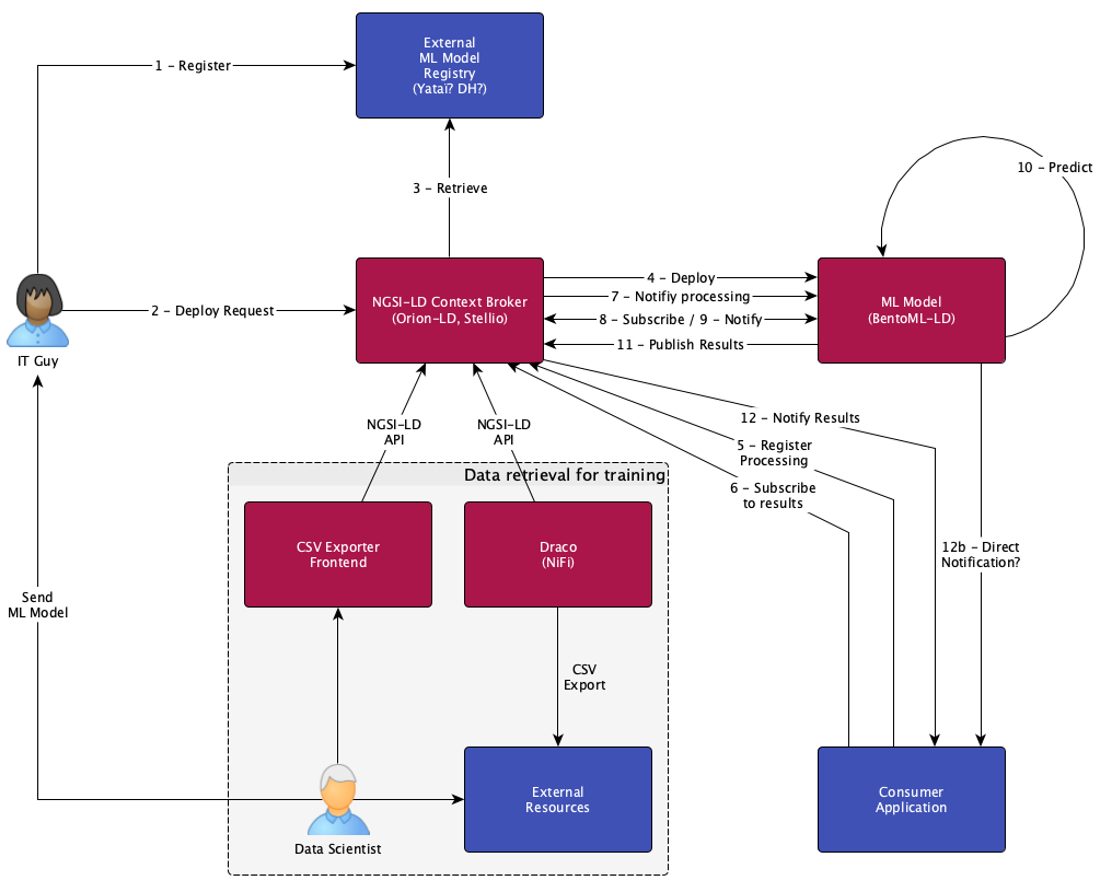

That diagram translates in the below detailed sequence diagram. That describes a typical use case of the consumption of a ML service by an **application**. The application is a simple application that displays prediction of the flow of a specific river (river Siagne) based on the precipitation of the day.

Data for that river are stored in the **Context Broker** as Properties of the entity Siagne (an entity of type River). Prediction on the flow will be triggered when the precipitation property for the day is updated in the entity.

We'll go through each step during this presentation.

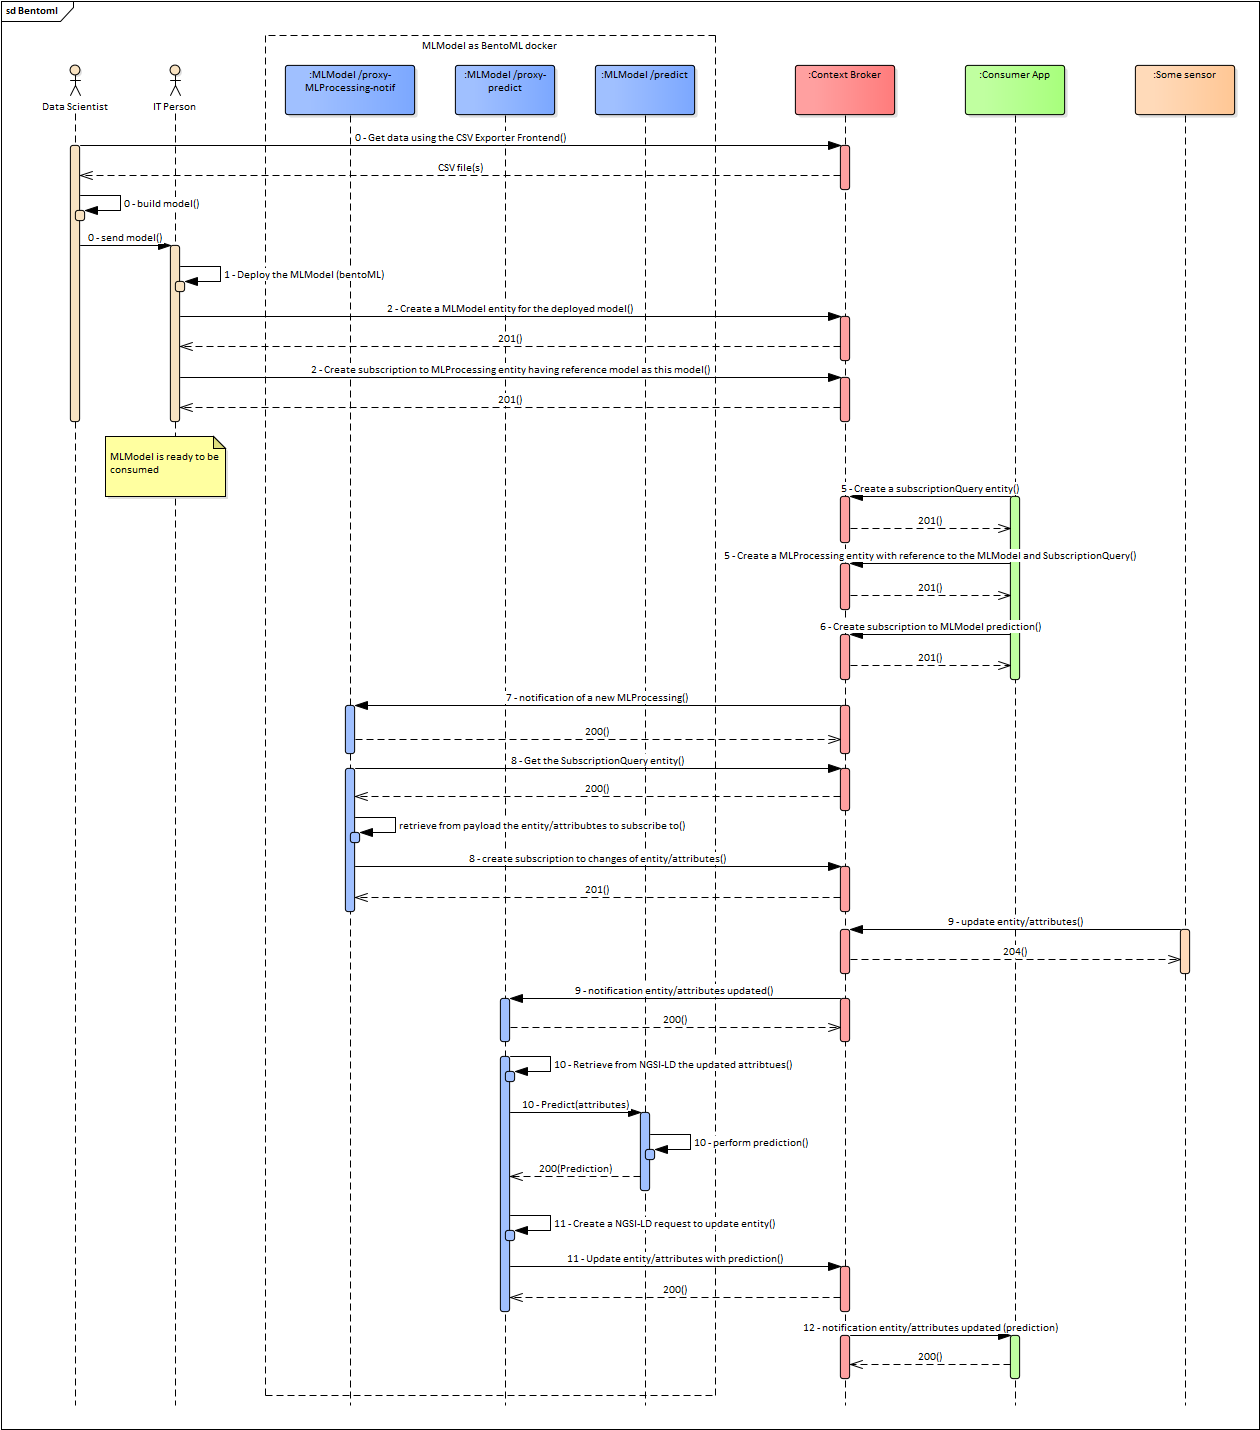

___
# 0 - Build the Machine Learning model
We build a very basic model, the main goal here being to demonstrate how a model can be easily deployed and served using BentoMl and a Context Broker.

___
# 1 - Model deployment
This is simply done with some **BentoML** Command Line Interface, by building a docker and deploying it.

___
# 2 -  Create a MLModel entity for the deployed model
Information on the created ML model are loaded into the Context Broker as a **MLModel** entity. Particularly the entity defines the input data required for the model and the output data where the prediction will be stored.

In [29]:
# Replace https://stellio-dev.eglobalmark.com with the url of your Context Broker
URL_ENTITIES = 'https://stellio-dev.eglobalmark.com/ngsi-ld/v1/entities/'
MLMODEL_UUID = 'urn:ngsi-ld:MLModel:flow:predict'

In [30]:
json_ = {
    '@context': [
        'https://raw.githubusercontent.com/easy-global-market/ngsild-api-data-models/master/mlaas/jsonld-contexts/mlaas-precipitation-contexts.jsonld'
],
    'id': MLMODEL_UUID,
    'type':'MLModel',
    'name': {
        'type': 'Property',
        'value': 'Flow Predict Siagne'
    },
    'description': {
        'type': 'Property',
        'value': 'Prediction of the Siagne flow from rain precipitation'
    },
    'algorithm': {
        'type': 'Property',
        'value': 'Linear Regression'
    },
    'version': {
        'type': 'Property',
        'value': 0.1
    },
    'inputAttributes': {
        'type': 'Property',
        'value': 'precipitation'
    },
    'outputAttributes': {
        'type': 'Property',
        'value': 'flow'
    }
}

In [31]:
r = requests.post(URL_ENTITIES, json=json_, headers=headers)
r.status_code

201

In [32]:
r = requests.get(URL_ENTITIES+MLMODEL_UUID, headers=headers)
r.json()

{'id': 'urn:ngsi-ld:MLModel:flow:predict',
 'type': 'https://uri.fiware.org/ns/data-models#MLModel',
 'https://smart-data-models.github.io/data-models/terms.jsonld#/definitions/version': {'type': 'Property',
  'value': 0.1},
 'description': {'type': 'Property',
  'value': 'Prediction of the Siagne flow from rain precipitation'},
 'name': {'type': 'Property', 'value': 'Flow Predict Siagne'},
 'https://uri.fiware.org/ns/data-models#algorithm': {'type': 'Property',
  'value': 'Linear Regression'},
 'https://uri.fiware.org/ns/data-models#inputAttributes': {'type': 'Property',
  'value': 'precipitation'},
 'https://uri.fiware.org/ns/data-models#outputAttributes': {'type': 'Property',
  'value': 'flow'},
 '@context': ['https://uri.etsi.org/ngsi-ld/v1/ngsi-ld-core-context.jsonld']}

___

# 2 -  Create a Subscription to MLProcessing entities
The way a consumer application uses the deployed model is by creating beforehand a **MLProcessing** entity, where it provides a link to an **SubscriptionQuery** entity that contains the query for the **MLModel** to get the input data.

Therefore, this step is about the MLModel to subscribe to any MLProcessing entities that contains a reference to its id. Once a MLProcessing entity using the MLModel will be created (or already exists), the MLModel will receive a notification with the appropriate information for querying the input data.

In [33]:
# Replace https://stellio-dev.eglobalmark.com with the url of your Context Broker
URL_SUBSCRIPTION = 'https://stellio-dev.eglobalmark.com/ngsi-ld/v1/subscriptions/'
SUBS_MLPROCESSING_UUID = 'urn:ngsi-ld:Subscription:MLModel:flow:predict:71dba318-2989-4c76-a22c-52a53f04759b'
ENDPOINT_SUBS_MLPROCESSING_NOTIF = 'http://10.5.1.217:5000/ngsi-ld/ml/processing'

In [34]:
json_ = {
    '@context': AT_CONTEXT,
    'id':SUBS_MLPROCESSING_UUID,
    'type':'Subscription',
    'entities': [
        {
          'type': 'MLProcessing'
        }
    ],
    'q': 'refMLModel=="'+MLMODEL_UUID+'"',
    'notification': {
        'endpoint': {
            'uri': ENDPOINT_SUBS_MLPROCESSING_NOTIF,
            'accept': 'application/json'
        },
        'attributes': ['refSubscriptionQuery']
    }
}

In [35]:
r = requests.post(URL_SUBSCRIPTION, json=json_, headers=headers)
r.status_code

201

In [36]:
r = requests.get(URL_SUBSCRIPTION+SUBS_MLPROCESSING_UUID, headers=headers)
r.json()

{'id': 'urn:ngsi-ld:Subscription:MLModel:flow:predict:71dba318-2989-4c76-a22c-52a53f04759b',
 'type': 'Subscription',
 'entities': [{'type': 'https://uri.fiware.org/ns/data-models#MLProcessing'}],
 'q': 'refMLModel=="urn:ngsi-ld:MLModel:flow:predict"',
 'notification': {'attributes': ['https://uri.fiware.org/ns/data-models#refSubscriptionQuery'],
  'format': 'normalized',
  'endpoint': {'uri': 'http://10.5.1.217:5000/ngsi-ld/ml/processing',
   'accept': 'application/json'},
  'timesSent': 0},
 'isActive': True,
 '@context': ['https://uri.etsi.org/ngsi-ld/v1/ngsi-ld-core-context.jsonld']}

___

# 6 - CHECK: Creation of Subscription to MLModel prediction
Just checking if the consumer app has correctly created the subscription to the **MLModel prediction**. We just do a **GET** on this susbcription.

In [37]:
SUBSCRIPTION_MLMODEL_PREDS = 'urn:ngsi-ld:Subscription:flow:predicted:4debd711-408a-4362-8352-9f885e7ca990'

In [38]:
r = requests.get(URL_SUBSCRIPTION+SUBSCRIPTION_MLMODEL_PREDS, headers=headers)
r.status_code

403

In [39]:
r.json()

{'detail': 'User is not authorized to access subscription urn:ngsi-ld:Subscription:flow:predicted:4debd711-408a-4362-8352-9f885e7ca990',
 'type': 'https://uri.etsi.org/ngsi-ld/errors/AccessDenied',
 'title': 'The request tried to access an unauthorized resource'}

___

# 8 - CHECK: Creation of Subscription to Input Data
Just checking if the MLModel has correctly created the subscription to the change of Input Data. We just do a **GET** on this susbcription.

In [40]:
SUBSCRIPTION_INPUT_DATA = 'urn:ngsi-ld:Subscription:input:data:2c30fa86-a25c-4191-8311-8954294e92b3'

In [41]:
r = requests.get(URL_SUBSCRIPTION+SUBSCRIPTION_INPUT_DATA, headers=headers)
r.status_code

200

In [42]:
r.json()

{'id': 'urn:ngsi-ld:Subscription:input:data:2c30fa86-a25c-4191-8311-8954294e92b3',
 'type': 'Subscription',
 'entities': [{'id': 'urn:ngsi-ld:River:014f5730-72ab-4554-a106-afbe5d4d9d26',
   'type': 'https://uri.fiware.org/ns/data-models#River'}],
 'watchedAttributes': ['precipitation'],
 'notification': {'attributes': ['https://smart-data-models.github.io/data-models/terms.jsonld#/definitions/precipitation'],
  'format': 'normalized',
  'endpoint': {'uri': 'http://10.5.1.217:5000/ngsi-ld/ml/predict',
   'accept': 'application/json'},
  'timesSent': 0},
 'isActive': True,
 '@context': ['https://uri.etsi.org/ngsi-ld/v1/ngsi-ld-core-context.jsonld']}

___

# 9 - Sensor update precipitation property
Some sensor updates the precipitation value of the **Siagne Entity**.

In [43]:
RIVER_SIAGNE_UUID = 'urn:ngsi-ld:River:014f5730-72ab-4554-a106-afbe5d4d9d26'

In [49]:
timezone_France = pytz.timezone('Europe/Paris')
observedAt = timezone_France.localize(datetime.now().replace(microsecond=0)).isoformat()
precipitation = 543.2

In [50]:
json_ = {
    '@context': AT_CONTEXT,
    'precipitation': [
        {
            'type': 'Property',
            'value': precipitation,
            'unitCode': 'MMT',
            'observedAt': observedAt
        }
    ]
}

In [51]:
r = requests.post(URL_ENTITIES+RIVER_SIAGNE_UUID+'/attrs', json=json_, headers=headers)
r.status_code

204

___

# 11 - CHECK: Update of Output Data (prediction)
Just checking if the MLModel has correctly updated the **flow** property of the Siagne entity.

In [52]:
r = requests.get(URL_ENTITIES+RIVER_SIAGNE_UUID, headers=headers)
r.status_code

200

In [53]:
r.json()

{'id': 'urn:ngsi-ld:River:014f5730-72ab-4554-a106-afbe5d4d9d26',
 'type': 'https://uri.fiware.org/ns/data-models#River',
 'https://smart-data-models.github.io/data-models/terms.jsonld#/definitions/flow': {'type': 'Property',
  'value': 711.92,
  'observedAt': '2021-05-12T08:24:46.000Z',
  'unitCode': 'MQS',
  'https://uri.fiware.org/ns/data-models#computedBy': {'type': 'Relationship',
   'object': 'urn:ngsi-ld:MLModel:flow:predict'}},
 'https://smart-data-models.github.io/data-models/terms.jsonld#/definitions/precipitation': {'type': 'Property',
  'value': 543.2,
  'observedAt': '2021-05-12T08:24:44.000Z',
  'unitCode': 'MMT'},
 'description': {'type': 'Property', 'value': 'River Siagne'},
 '@context': ['https://uri.etsi.org/ngsi-ld/v1/ngsi-ld-core-context.jsonld']}